This portion of the notebook will be feature engineering.

In [1]:
# get some libraries that will be useful

import re
import numpy as np # linear algebra
import pandas as pd
import seaborn as sns
import string
import matplotlib.pyplot as plt
import pandas_datareader as dr
#To remove weekends from dataset
from pandas.tseries.offsets import BDay

# necessary libraries for wordcloud
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from PIL import Image

# the Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
# function to split the data for cross-validation
from sklearn.model_selection import train_test_split
# function for transforming documents into counts
#words
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

# function for encoding categories
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier, SGDRegressor,LogisticRegression
#keras modeling
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.layers.convolutional import Convolution1D
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
%matplotlib inline

C:\Users\PC\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


In [2]:
# grab the data #we will first grab the news data set first
combined_news = pd.read_csv("../data/final_dataframe.csv")

In [3]:
combined_news.head()

,Date,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,...,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,upordown
0,2008-08-08,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",0.0
1,2008-08-11,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",0.0
2,2008-08-12,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",1.0
3,2008-08-13,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',"b""The commander of a Navy air reconnaissance s...",...,b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...,0.0
4,2008-08-14,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refus

In [4]:
#this is our Y variable.
combined_news['upordown'].value_counts(normalize= True)

0.0    0.603821
1.0    0.396179
Name: upordown, dtype: float64

### Baseline Accuracy
Our baseline accuracy is 60%.

## Preprocessor function to clean the text 

The final iteration of cleaner(text) does the following:

1. Grouping into stems
2. Excluding stopwords
3. Removing punctuation
4. Removing digits
5. Removing spaces

### This function will be used as preprocessor on both CountVectorizer and TfidfVectorizer

Some words share the same stem and can be combined in the next round of CountVectorize: file/files, game/games, http/https, imgur/imgur com, run/running, start/started, thing/things, tried/try/trying, use/used/using, windows/windows 10, work/working/works.

We will use porter stemmer to clean the words 

In [5]:
def cleaner(text):
    stemmer = PorterStemmer()                                          # groups words having the same stems
    stop = stopwords.words('english')                                  # excludes stop words
    text = text.replace('ps4', ' ')
    text = text.replace('ps', ' ')
    text = text.replace('game', ' ')
    text = text.replace('xbox', ' ')
    text = text.replace('xbox one', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))   # removes punctuation
    text = text.translate(str.maketrans('', '', string.digits))        # removes digits
    text = text.lower().strip()                                        # removes spaces
    final_text = []
    for w in text.split():
        if w not in stop:
            final_text.append(stemmer.stem(w.strip()))
    return ' '.join(final_text)

In [6]:
#Lets split our dataframe first into training and test dataset.
#train = combined_news[combined_news['Date'] < '2014-01-01'] #train data will consist from 2008 to 2014 (~4 years)
#y_train =  train["upordown"]
#test = combined_news[combined_news['Date'] > '2013-12-31'] #test date will consist from 2013 to 2016 (~3years)
#y_test =  train["upordown"]

X = combined_news
y = combined_news['upordown']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33,stratify = y, random_state=42)

In [7]:
#to form a string for all top 25 of news headlines for X_train
trainheadlines = []
for row in range(0,len(X_train.index)):
    trainheadlines.append(' '.join(str(x) for x in X_train.iloc[row,2:27]))

# Let try Countvectorizer with Logistic Regression

In [8]:
basicvectorizer = CountVectorizer(preprocessor=cleaner,  
                                  min_df=0.03, 
                                  max_df=0.97, 
                                  max_features = 200000, 
                                  ngram_range = (2, 2))

basictrain = basicvectorizer.fit_transform(trainheadlines)

In [9]:
basicmodel = LogisticRegression()
basicmodel = basicmodel.fit(basictrain, y_train)

In [10]:
#Create test headlines
testheadlines = []

for row in range(0,len(X_val.index)):
    
    testheadlines.append(' '.join(str(x) for x in X_val.iloc[row,2:27]))
basictest = basicvectorizer.transform(testheadlines)
preds1 = basicmodel.predict(basictest)
acc1=accuracy_score(y_val, preds1)

In [11]:
print('Logic Regression 1 accuracy: ',acc1 )
#our accuracy is only 56%

Logic Regression 1 accuracy:  0.563165905631659


In [12]:
basicwords = basicvectorizer.get_feature_names()

basiccoeffs = basicmodel.coef_.tolist()[0]

coeffdf = pd.DataFrame({'Word' : basicwords, 
                        'Coefficient' : basiccoeffs})

coeffdf = coeffdf.sort_values(['Coefficient', 'Word'], ascending=[0, 1])

coeffdf.head(5) #these are words that contributes to the rise of VIX.

,Word,Coefficient
3,around world,0.618227
39,least peopl,0.612526
69,sex abus,0.531059
42,new law,0.524573
51,offici said,0.450549


In [13]:
coeffdf.tail(5) #these are words that contributes to the fall of VIX

,Word,Coefficient
12,court rule,-0.402620
52,offici say,-0.405361
17,drug cartel,-0.583001
84,uk govern,-0.640962
30,intellig agenc,-0.726090


# Lets us try TDIF with logistic Regression

In [14]:
advancedvectorizer = TfidfVectorizer(preprocessor=cleaner, 
                                     min_df=0.03, 
                                     max_df=0.97, 
                                     max_features = 200000, 
                                     ngram_range = (1, 2))

advancedtrain = advancedvectorizer.fit_transform(trainheadlines)

In [15]:
advancedmodel = LogisticRegression()
advancedmodel = advancedmodel.fit(advancedtrain, y_train)

In [16]:
testheadlines = []
for row in range(0,len(X_val.index)):
    testheadlines.append(' '.join(str(x) for x in X_val.iloc[row,2:27]))
advancedtest = advancedvectorizer.transform(testheadlines)
preds2 = advancedmodel.predict(advancedtest)
acc2=accuracy_score(y_val, preds2)

In [17]:
print('Logic Regression 2 accuracy: ', acc2) #60% accuracy

Logic Regression 2 accuracy:  0.604261796042618


In [18]:
advwords = advancedvectorizer.get_feature_names()
advcoeffs = advancedmodel.coef_.tolist()[0]
advcoeffdf = pd.DataFrame({'Words' : advwords, 
                        'Coefficient' : advcoeffs})
advcoeffdf = advcoeffdf.sort_values(['Coefficient', 'Words'], ascending=[0, 1])
advcoeffdf.head(5)#these are words that contributes to the rise of VIX.

,Words,Coefficient
69,amp,1.110758
1077,norway,1.100748
295,citizen,1.011830
1618,train,1.003494
972,marijuana,1.000381


In [19]:
advcoeffdf.tail(5)#these are words that contributes to the fall of VIX.

,Words,Coefficient
1087,obama,-0.876816
508,egyptian,-0.877877
1479,squar,-0.912582
627,flood,-1.004526
997,mexico,-1.025604


# Let us try with Naive Bayes + TFID

In [20]:
advancedvectorizer = TfidfVectorizer(preprocessor=cleaner, 
                                     min_df=0.03, 
                                     max_df=0.97, 
                                     max_features = 200000, 
                                     ngram_range = (2, 2))
advancedtrain = advancedvectorizer.fit_transform(trainheadlines)

In [21]:
print(advancedtrain.shape)

(1332, 104)


In [22]:
advancedmodel = MultinomialNB(alpha=0.01)
advancedmodel = advancedmodel.fit(advancedtrain, y_train)
testheadlines = []
for row in range(0,len(X_val.index)):
    testheadlines.append(' '.join(str(x) for x in X_val.iloc[row,2:27]))
advancedtest = advancedvectorizer.transform(testheadlines)
preds4 = advancedmodel.predict(advancedtest)
acc4=accuracy_score(y_val, preds4)

In [23]:
print('NBayes 1 accuracy: ', acc4) # accuracy 60% 

NBayes 1 accuracy:  0.6057838660578386


In [24]:
nbwords = advancedvectorizer.get_feature_names()
nbcoeffs = advancedmodel.coef_.tolist()[0]
nbcoeffdf = pd.DataFrame({'Words' : nbwords, 
                        'Coefficient' : nbcoeffs})
nbcoeffdf = advcoeffdf.sort_values(['Coefficient', 'Words'], ascending=[0, 1])
nbcoeffdf.head(5)

,Words,Coefficient
69,amp,1.110758
1077,norway,1.100748
295,citizen,1.011830
1618,train,1.003494
972,marijuana,1.000381


In [25]:
nbcoeffdf.tail(5)

,Words,Coefficient
1087,obama,-0.876816
508,egyptian,-0.877877
1479,squar,-0.912582
627,flood,-1.004526
997,mexico,-1.025604


# Random Forest  with Tfid

In [26]:
advancedvectorizer = TfidfVectorizer(preprocessor=cleaner, 
                                     min_df=0.03, 
                                     max_df=0.97, 
                                     max_features = 200000, 
                                     ngram_range = (2, 2))
advancedtrain = advancedvectorizer.fit_transform(trainheadlines)

In [27]:
print(advancedtrain.shape)

(1332, 104)


In [28]:
advancedmodel = RandomForestClassifier()
advancedmodel = advancedmodel.fit(advancedtrain, y_train)
testheadlines = []
for row in range(0,len(X_val.index)):
    testheadlines.append(' '.join(str(x) for x in X_val.iloc[row,2:27]))
advancedtest = advancedvectorizer.transform(testheadlines)
preds7 = advancedmodel.predict(advancedtest)
acc7 = accuracy_score(y_val, preds7)

In [29]:
print('RF 2 accuracy: ', acc7)

RF 2 accuracy:  0.5220700152207002


In [30]:
rfwords = advancedvectorizer.get_feature_names()
rfcoeffs = advancedmodel.feature_importances_.tolist()[0]
rfcoeffdf = pd.DataFrame({'Words' : rfwords, 
                        'Coefficient' : rfcoeffs})
rfcoeffdf = rfcoeffdf.sort_values(['Coefficient', 'Words'], ascending=[0, 1])
rfcoeffdf.head(5)

,Words,Coefficient
0,air strike,0.009386
1,al jazeera,0.009386
2,al qaeda,0.009386
3,around world,0.009386
4,barack obama,0.009386


In [31]:
rfcoeffdf.tail(5)

,Words,Coefficient
99,world largest,0.009386
100,world war,0.009386
101,year ago,0.009386
102,year old,0.009386
103,year prison,0.009386


# MACHINE LEARNING

## LSTM + tokenizer

In [32]:
# We will redefine again before we head into the machine learning.

In [33]:
X = combined_news
y = combined_news['upordown']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33,stratify = y, random_state=42)

In [34]:
#to form a string for all top 25 of news headlines for X_train
trainheadlines = []
for row in range(0,len(X_train.index)):
    trainheadlines.append(' '.join(str(x) for x in X_train.iloc[row,2:27]))

In [35]:
#Create test headlines
testheadlines = []
for row in range(0,len(X_val.index)):
    testheadlines.append(' '.join(str(x) for x in X_val.iloc[row,2:27]))
basictest = basicvectorizer.transform(testheadlines)
preds1 = basicmodel.predict(basictest)
acc1=accuracy_score(y_val, preds1)

### Next we will vectorize the text samples into a 2D integer tensor for processing

In [36]:
#num_words - This will be the maximum number of words 
#from our resulting tokenized data vocabulary which are to be used, 
#truncated after the 10000 most common words in our case.
tokenizer = Tokenizer(num_words=10000)
# Tokenize our training data'trainheadlines'
tokenizer.fit_on_texts(trainheadlines)
# Encode training data sentences into sequences for both train and test data.
sequences_train = tokenizer.texts_to_sequences(trainheadlines)
sequences_test = tokenizer.texts_to_sequences(testheadlines)

In [37]:
print('Pad sequences (samples x time)')

#Features for model training
#nb_classes - total number of classes.
nb_classes = 2
# maxlen is feature of maximum sequence length for padding our encoded sentences
maxlen = 200

# Pad the training sequences as we need our encoded sequences to be of the same length. 
# use that to pad all other sequences with extra '0's at the end ('post') and
# will also truncate any sequences longer than maximum length from the end ('post') as well. 
X_train = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_val = sequence.pad_sequences(sequences_test, maxlen=maxlen)

#convert them into array before we put them into model
Y_train = np.array(y_train)
Y_val = np.array(y_val)

# np_utils.to_categorical to convert array of labeled data(from 0 to nb_classes-1) to one-hot vector.
Y_train = np_utils.to_categorical(Y_train, 2)
Y_val = np_utils.to_categorical(Y_val, 2)

#print out X_train and X_test shape.
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('y_train shape:', Y_train.shape)
print('y_val shape:', Y_val.shape)

Pad sequences (samples x time)
X_train shape: (1332, 200)
X_val shape: (657, 200)
y_train shape: (1332, 2)
y_val shape: (657, 2)


# 3 layers of Stacked LSTM for sequence classification

Sequence classification is a predictive modeling problem where you have some sequence of inputs over space or time and the task is to predict a category for the sequence which may apply in this case.

In this model, we stack 3 LSTM layers on top of each other, making the model capable of learning higher-level temporal representations.

The first two LSTMs return their full output sequences, but the last one only returns the last step in its output sequence, thus dropping the temporal dimension (i.e. converting the input sequence into a single vector).

In [38]:
print('Build LSTM model...')
# expected input data shape: (batch_size, timesteps, data_dim)
data_dim = 16
timesteps = 8
max_features = 10000
#intialize model
model = Sequential()
#Embedding with 128
model.add(Embedding(max_features, 128))
# returns 16 sequences of vectors of dimension 32
model.add(LSTM(32, return_sequences=True,input_shape=(timesteps, 16)))  
# returns a sequence of vectors of dimension 32
model.add(LSTM(32, return_sequences=True)) 
# return a single vector of dimension 32
model.add(LSTM(32))  
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
#Compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Build LSTM model...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          20608     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 1,317

In [39]:
# Final evaluation of the model
history = model.fit(X_train, Y_train,
          batch_size=64, epochs=3,
          validation_data=(X_val, Y_val))

score, acc = model.evaluate(X_val, Y_val,batch_size=64)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1332 samples, validate on 657 samples
Epoch 1/3
1332/1332 [==============================] - 15s 11ms/step - loss: 0.6750 - accuracy: 0.5961 - val_loss: 0.6598 - val_accuracy: 0.6043
Epoch 2/3
1332/1332 [==============================] - 14s 11ms/step - loss: 0.5614 - accuracy: 0.6517 - val_loss: 0.6032 - val_accuracy: 0.6895
Epoch 3/3
657/657 [==============================] - 2s 3ms/step


In [40]:
print("Generating test predictions...")
preds15 = model.predict_classes(X_val, verbose=0)
acc15 = accuracy_score(y_val, preds15)
print('prediction accuracy: ', acc15)

Generating test predictions...
prediction accuracy:  0.7366818873668188


#### Visualizing model training

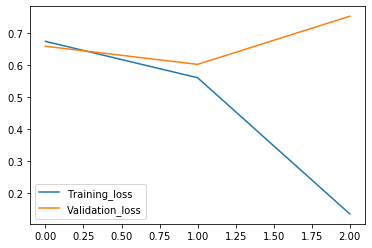

In [41]:
plt.plot(history.history['loss'], label='Training_loss')
plt.plot(history.history['val_loss'], label='Validation_loss')
plt.legend();

Using the history object, plot the model's accuracy (for both train and test).

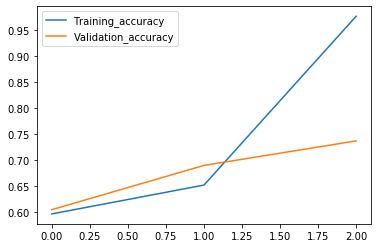

In [42]:
plt.plot(history.history['accuracy'], label= 'Training_accuracy')
plt.plot(history.history['val_accuracy'], label= 'Validation_accuracy')
plt.legend();

# LSTM and Convolutional Neural Network For Sequence Classification

Convolutional neural networks excel at learning the spatial structure in input data. Our dataset does have a one-dimensional spatial structure in the sequence of words in reviews and the CNN may be able to pick out invariant features for good and bad sentiment. This learned spatial features may then be learned as sequences by an LSTM layer.

In [43]:
#num_words - This will be the maximum number of words 
#from our resulting tokenized data vocabulary which are to be used, 
#truncated after the 10000 most common words in our case.
tokenizer = Tokenizer(num_words=10000)
# Tokenize our training data'trainheadlines'
tokenizer.fit_on_texts(trainheadlines)

sequences_train = tokenizer.texts_to_sequences(trainheadlines)
sequences_test = tokenizer.texts_to_sequences(testheadlines)


In [44]:
# maxlen is feature of maximum sequence length for padding our encoded sentences

maxlen = 200

# truncate and pad input sequences
X_train = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_val = sequence.pad_sequences(sequences_test, maxlen=maxlen)

#convert them into array before we put them into model
Y_train = np.array(y_train)
Y_val = np.array(y_val)

# np_utils.to_categorical to convert array of labeled data(from 0 to nb_classes-1) to one-hot vector.
Y_train = np_utils.to_categorical(Y_train, 2)
Y_val = np_utils.to_categorical(Y_val, 2)

We can now define our convolutional neural network model. This time, after the Embedding input layer, we insert a Conv1D layer. This convolutional layer has 32 feature maps and reads embedded word representations 3 vector elements of the word embedding at a time.

The convolutional layer is followed by a 1D max pooling layer with a length and stride of 2 that halves the size of the feature maps from the convolutional layer.

In [45]:
# create the model
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))

model.add(Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          12320     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 1,345,722
Trainable params: 1,345,722
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
# Final evaluation of the model
history = model.fit(X_train, Y_train,
          batch_size=64, epochs=5,
          validation_data=(X_val, Y_val))
score, acc = model.evaluate(X_val, Y_val,batch_size=64)

print('Test score:', acc)

Train on 1332 samples, validate on 657 samples
Epoch 1/5
1332/1332 [==============================] - 9s 7ms/step - loss: 0.6642 - accuracy: 0.6036 - val_loss: 0.6196 - val_accuracy: 0.6043
Epoch 2/5
1332/1332 [==============================] - 8s 6ms/step - loss: 0.4640 - accuracy: 0.7061 - val_loss: 0.2551 - val_accuracy: 0.9954
Epoch 3/5
1332/1332 [==============================] - 8s 6ms/step - loss: 0.0767 - accuracy: 1.0000 - val_loss: 0.0628 - val_accuracy: 0.9833
Epoch 4/5
1332/1332 [==============================] - 8s 6ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0161 - val_accuracy: 0.9970
Epoch 5/5
657/657 [==============================] - 1s 1ms/step
Test score: 0.9954338073730469


In [47]:
print("Generating test predictions...")
preds15 = model.predict_classes(X_val, verbose=0)
acc15 = accuracy_score(y_val, preds15)
print('prediction accuracy: ', acc15)

Generating test predictions...
prediction accuracy:  0.9954337899543378


#### Visualizing model training

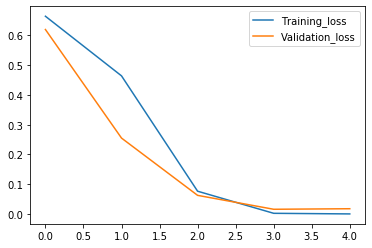

In [48]:
plt.plot(history.history['loss'], label='Training_loss')
plt.plot(history.history['val_loss'], label='Validation_loss')
plt.legend();

### Using the history object, plot the model's accuracy (for both train and test).

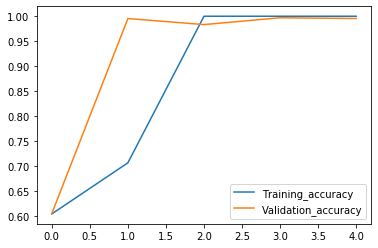

In [49]:
plt.plot(history.history['accuracy'], label= 'Training_accuracy')
plt.plot(history.history['val_accuracy'], label= 'Validation_accuracy')
plt.legend();

A combination of LSTM and Convolutional Neural Network seem to produce the best results.

In [50]:
df = pd.DataFrame(model.predict_classes(X_val, verbose=0))

## ROC_AUC

In [51]:
# Create a dataframe called pred_df that contains:
# 1. The list of true values of our validation set.
# 2. The list of predicted probabilities based on our model.

true_y = [i[1] for i in Y_val]

pred_proba = [i[1] for i in model.predict_proba(X_val)]

pred_df = pd.DataFrame({'true_values': true_y,'pred_probs':pred_proba})
pred_df.head()

,true_values,pred_probs
0,0.0,0.000233
1,1.0,0.999228
2,0.0,0.000595
3,0.0,0.000040
4,1.0,0.999029


In [52]:
# Produce a summary table of the tuned classifiers
summary = pd.DataFrame({
    'model': models,
    'parameters': parameters,
    'Best AUC cross validation score': best_score,
    'Training dataset accuracy': train_accuracy,
    'Validation dataset accuracy': val_accuracy,
    'Training dataset AUC score': train_roc_auc,
    'Validation dataset AUC score': val_roc_auc,
    'Validation dataset sensitivity': sensitivity
    })

pd.set_option('display.max_colwidth', -1)
summary.sort_values('Validation dataset AUC score', ascending=False).reset_index(drop=True)

NameError: name 'models' is not defined

In [ ]:
# Plot ROC_AUC Curve

#Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);
